# Project Structure

## Phase 1: Environment & Intelligent Data Loading
- What: Set up workspace and locate data.
- Action: Filter strictly for train_real, train_synthetic, and test_set (4 classes).

## Phase 2: Feature Extraction (MediaPipe)
- What: Convert video pixels to raw skeletal coordinates.
- Optimization (Normalization): As we extract, we immediately calculate $x_{new} = x_{raw} - x_{hip\_center}$ to make the pose "translation invariant."
- Optimization (Caching): Save these normalized (but original) keypoints to disk (.pkl) so we don't have to re-run MediaPipe.

## Phase 3: Data Augmentation & Sequence Engineering
(This is where the missing piece fits)
- What: Expand the dataset mathematically and prepare time windows.
- Step 3.1: Augmentation (The Multiplier):
  - Load the cached skeletons from Phase 2.
  - Horizontal Flip: Create a copy of every sequence where we multiply $x$ coordinates by $-1$ (simulating the person facing the other way).
  - Result: Your training dataset size instantly doubles (e.g., from 500 videos to 1000).
- Step 3.2: Windowing:
  - Slice both the Original and Augmented skeleton streams into 30-frame sliding windows.
- Why here? We do it after caching (to keep the cache file small) but before training (so the model sees both versions).

## Phase 4: Model Architecture
- What: Build the Bidirectional LSTM.
- Input: Now receives both the original and the mathematically flipped sequences.

## Phase 5: Training & Tuning
- What: Train with Early Stopping and Checkpoints.

## Phase 6: Evaluation
- What: Test on test_set (Real data only, no augmentation needed for testing).

## Environment Setup & Data Organization

Objective: To prepare the Python environment and transform the uploaded raw.zip data into a standardized project structure (train_real, train_synthetic, test_set).

What this code does:

Mounts Google Drive: Connects your Colab notebook to your file system.

Extracts Data: Unzips raw.zip if it hasn't been extracted yet.

Auto-Reorganization: This is the "Intelligent" part. It checks if your folders have the old "messy" names (final_kaggle..., my_test_video_1) and automatically renames them to the clean standard we agreed on (train_real, test_set). This ensures your code is clean from line 1.

Verification: It counts the videos in every class to ensure we have the expected volume (e.g., ~100 synthetic videos per class) and filters out any classes we don't want (like "hammer curl").

Why is this needed? Deep learning models are sensitive to data errors. By enforcing this strict structure now, we prevent "File Not Found" errors and class imbalance issues in later steps.

Expected Output: A printout confirming the renamed folders and a table showing exactly how many clean videos are ready for training.

In [1]:
# ==========================================
# Phase 1: Environment & Intelligent Data Loading
# ==========================================

import os
import shutil
import zipfile
from pathlib import Path
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define Project Paths
PROJECT_ROOT = Path('/content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach')
DATA_DIR = PROJECT_ROOT / 'data'
RAW_ZIP_PATH = DATA_DIR / 'raw.zip'

# 3. Define the Clean Target Structure
# We map the "Old/Messy" names found in the zip to "Clean/Standard" names
FOLDER_MAPPING = {
    'final_kaggle_with_additional_video': 'train_real',
    'synthetic_dataset': 'train_synthetic',
    'my_test_video_1': 'test_set'
}

# 4. Define Target Classes (Dropping 'hammer curl')
TARGET_CLASSES = [
    'barbell biceps curl',
    'push-up',
    'shoulder press',
    'squat'
]

def setup_workspace():
    print(f"🚀 Setting up workspace at: {PROJECT_ROOT}")

    # Step A: Extract Zip if needed
    if not (DATA_DIR / 'train_real').exists() and RAW_ZIP_PATH.exists():
        print(f"📦 Extracting raw.zip...")
        with zipfile.ZipFile(RAW_ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(DATA_DIR)
        print("✅ Extraction complete.")
    elif (DATA_DIR / 'train_real').exists():
        print("✅ Data already extracted.")
    else:
        print(f"❌ Error: raw.zip not found at {RAW_ZIP_PATH}")
        return

    # Step B: Auto-Reorganize Folders (Rename messy -> clean)
    print("\n🧹 Standardizing folder structure...")
    for old_name, new_name in FOLDER_MAPPING.items():
        old_path = DATA_DIR / old_name
        new_path = DATA_DIR / new_name

        # Handle the nested synthetic case specifically
        if old_name == 'synthetic_dataset':
            nested_path = old_path / 'synthetic_dataset'
            if nested_path.exists():
                print(f"   • Fixing nested synthetic folder...")
                # Move contents up
                for item in nested_path.iterdir():
                    shutil.move(str(item), str(old_path))
                nested_path.rmdir()

        if old_path.exists() and not new_path.exists():
            print(f"   • Renaming '{old_name}' -> '{new_name}'")
            old_path.rename(new_path)
        elif new_path.exists():
            print(f"   • '{new_name}' already exists.")

    # Remove the unwanted 'similar_dataset' if it exists
    messy_path = DATA_DIR / 'similar_dataset'
    if messy_path.exists():
        print("   • Ignoring/Removing 'similar_dataset' (Noise source)")
        # shutil.rmtree(messy_path) # Uncomment to actually delete it

def verify_dataset():
    """Count and verify the clean dataset"""
    print(f"\n📊 Verifying Dataset Integrity...")
    print(f"{'Source':<15} | {'Class':<20} | {'Videos':<10} | {'Status'}")
    print("-" * 60)

    total_count = 0
    all_videos = {}

    for source in ['train_real', 'train_synthetic', 'test_set']:
        source_path = DATA_DIR / source
        all_videos[source] = {}

        if not source_path.exists():
            print(f"{source:<15} | {'MISSING':<20} | {'0':<10} | ❌ Path not found")
            continue

        for exercise in TARGET_CLASSES:
            ex_path = source_path / exercise

            # Find videos (case insensitive extensions)
            videos = []
            if ex_path.exists():
                for ext in ['*.mp4', '*.MP4', '*.MOV', '*.mov', '*.avi']:
                    videos.extend(ex_path.glob(ext))

            count = len(videos)
            total_count += count
            all_videos[source][exercise] = videos

            # Quality Checks
            status = "✅ OK"
            if count == 0: status = "❌ EMPTY"
            elif source == 'train_synthetic' and count != 100: status = "⚠️ IMBALANCE"

            print(f"{source:<15} | {exercise:<20} | {count:<10} | {status}")

    print("-" * 60)
    print(f"🎉 Total Clean Videos Ready: {total_count}")
    return all_videos

# --- Run the Setup ---
setup_workspace()
dataset_config = verify_dataset()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 Setting up workspace at: /content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach
✅ Data already extracted.

🧹 Standardizing folder structure...
   • 'train_real' already exists.
   • 'train_synthetic' already exists.
   • 'test_set' already exists.

📊 Verifying Dataset Integrity...
Source          | Class                | Videos     | Status
------------------------------------------------------------
train_real      | barbell biceps curl  | 25         | ✅ OK
train_real      | push-up              | 25         | ✅ OK
train_real      | shoulder press       | 25         | ✅ OK
train_real      | squat                | 25         | ✅ OK
train_synthetic | barbell biceps curl  | 100        | ✅ OK
train_synthetic | push-up              | 100        | ✅ OK
train_synthetic | shoulder press       | 100        | ✅ OK
train_synthetic | squat                | 100 

## Feature Extraction

In [3]:
pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 38.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled p

In [3]:
# --- QUICK RESTORE CONFIG ---
from pathlib import Path
TARGET_CLASSES = ['barbell biceps curl', 'push-up', 'shoulder press', 'squat']
DATA_DIR = Path('/content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach/data')

def scan_existing_dataset():
    all_videos = {}
    for source in ['train_real', 'train_synthetic', 'test_set']:
        source_path = DATA_DIR / source
        all_videos[source] = {}
        for exercise in TARGET_CLASSES:
            ex_path = source_path / exercise
            videos = []
            if ex_path.exists():
                for ext in ['*.mp4', '*.MP4', '*.MOV', '*.mov', '*.avi']:
                    videos.extend(ex_path.glob(ext))
            all_videos[source][exercise] = videos
    return all_videos

dataset_config = scan_existing_dataset()
print("✅ Config Restored.")

✅ Config Restored.


In [4]:
# ==========================================
# Phase 2: Feature Extraction (Self-Contained Fix)
# ==========================================
import cv2
import mediapipe as mp
import numpy as np
import pickle
from tqdm.notebook import tqdm
from pathlib import Path
from google.colab import drive

# 1. Setup Paths (Redefined here to fix NameError)
# Ensure Drive is mounted
if not Path('/content/drive').exists():
    drive.mount('/content/drive')

PROJECT_ROOT = Path('/content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach')
PROCESSED_DIR = PROJECT_ROOT / 'processed'
FEATURES_DIR = PROCESSED_DIR / 'pose_features'
FEATURES_DIR.mkdir(parents=True, exist_ok=True)

# 2. Initialize MediaPipe
mp_pose = mp.solutions.pose
pose_model = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=2,      # 2 = Best accuracy
    smooth_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

def get_center_point(landmarks, idx1, idx2):
    """Calculate the midpoint between two landmarks (hips)"""
    p1 = np.array([landmarks[idx1].x, landmarks[idx1].y, landmarks[idx1].z])
    p2 = np.array([landmarks[idx2].x, landmarks[idx2].y, landmarks[idx2].z])
    return (p1 + p2) / 2.0

def extract_pose_data(video_path):
    cap = cv2.VideoCapture(str(video_path))
    frames_data = []

    if not cap.isOpened(): return None

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break

        # Convert to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose_model.process(frame_rgb)

        if results.pose_landmarks:
            lm = results.pose_landmarks.landmark

            # --- NORMALIZATION ---
            # Indices: 23 = Left Hip, 24 = Right Hip
            hip_center = get_center_point(lm, 23, 24)

            frame_row = []
            for landmark in lm:
                # Subtract hip center from every joint
                frame_row.extend([
                    landmark.x - hip_center[0],
                    landmark.y - hip_center[1],
                    landmark.z - hip_center[2]
                ])
            frames_data.append(frame_row)
        else:
            # Padding if no person detected
            frames_data.append([0] * 99)

    cap.release()
    return np.array(frames_data)

def process_dataset_features(dataset_config):
    print(f"⚙️ Starting Feature Extraction...")
    print(f"   Saving to: {FEATURES_DIR}")

    processed_cnt = 0
    skipped_cnt = 0

    for source, exercises in dataset_config.items():
        for exercise, videos in exercises.items():

            # Progress bar for this batch
            pbar = tqdm(videos, desc=f"{source}/{exercise}", leave=False)

            for video_path in pbar:
                # Unique filename: source_exercise_videoname.pkl
                safe_name = f"{source}_{exercise}_{video_path.stem}.pkl"
                cache_path = FEATURES_DIR / safe_name

                # Skip if already done
                if cache_path.exists():
                    skipped_cnt += 1
                    continue

                # Extract
                poses = extract_pose_data(video_path)

                if poses is not None and len(poses) > 0:
                    with open(cache_path, 'wb') as f:
                        pickle.dump({
                            'poses': poses,
                            'label': exercise,
                            'source': source
                        }, f)
                    processed_cnt += 1

    print(f"\n✅ Extraction Complete!")
    print(f"   🆕 Processed: {processed_cnt}")
    print(f"   ⏩ Cached (Skipped): {skipped_cnt}")

# Run Phase 2
# Note: This relies on 'dataset_config' from Phase 1.
# If 'dataset_config' is also lost, you might need to re-run the quick config block I gave earlier.
if 'dataset_config' in globals():
    process_dataset_features(dataset_config)
else:
    print("❌ Error: dataset_config is missing. Please run the 'Quick Config' block below to restore it.")

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


⚙️ Starting Feature Extraction...
   Saving to: /content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach/processed/pose_features


train_real/barbell biceps curl:   0%|          | 0/25 [00:00<?, ?it/s]

train_real/push-up:   0%|          | 0/25 [00:00<?, ?it/s]

train_real/shoulder press:   0%|          | 0/25 [00:00<?, ?it/s]

train_real/squat:   0%|          | 0/25 [00:00<?, ?it/s]

train_synthetic/barbell biceps curl:   0%|          | 0/100 [00:00<?, ?it/s]

train_synthetic/push-up:   0%|          | 0/100 [00:00<?, ?it/s]

train_synthetic/shoulder press:   0%|          | 0/100 [00:00<?, ?it/s]

train_synthetic/squat:   0%|          | 0/100 [00:00<?, ?it/s]

test_set/barbell biceps curl:   0%|          | 0/4 [00:00<?, ?it/s]

test_set/push-up:   0%|          | 0/3 [00:00<?, ?it/s]

test_set/shoulder press:   0%|          | 0/4 [00:00<?, ?it/s]

test_set/squat:   0%|          | 0/4 [00:00<?, ?it/s]


✅ Extraction Complete!
   🆕 Processed: 515
   ⏩ Cached (Skipped): 0


## Data Augmentation & Sequence Engineering

In [5]:
# ==========================================
# Phase 3: Data Augmentation & Sequence Creation (Self-Contained)
# ==========================================

import numpy as np
import pickle
import glob
import os
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from google.colab import drive

# 1. Robust Path Setup (Guaranteed to work)
# Ensures we can run this cell independently
if not Path('/content/drive').exists():
    drive.mount('/content/drive')

PROJECT_ROOT = Path('/content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach')
PROCESSED_DIR = PROJECT_ROOT / 'processed'
FEATURES_DIR = PROCESSED_DIR / 'pose_features'

# Define Classes (Must match your folder names exactly)
TARGET_CLASSES = ['barbell biceps curl', 'push-up', 'shoulder press', 'squat']
LABEL_MAP = {cls: i for i, cls in enumerate(TARGET_CLASSES)}

# Configuration
SEQUENCE_LENGTH = 30  # 30 frames (approx 1 second of video)
STEP_SIZE = 1         # Slide 1 frame at a time (Maximum data generation)

def load_and_augment_data():
    print(f"🔄 Loading features from: {FEATURES_DIR}")

    sequences = []
    labels = []

    # Get all .pkl files from Phase 2
    pkl_files = glob.glob(str(FEATURES_DIR / "*.pkl"))

    if len(pkl_files) == 0:
        print("❌ Error: No feature files found. Please let Phase 2 finish completely.")
        return None, None

    print(f"   Found {len(pkl_files)} videos. Processing...")

    for pkl_path in tqdm(pkl_files, desc="Augmenting"):
        try:
            with open(pkl_path, 'rb') as f:
                data = pickle.load(f)
        except Exception as e:
            print(f"⚠️ Warning: Corrupt file {pkl_path}, skipping.")
            continue

        raw_poses = data['poses'] # Shape: (frames, 99)
        label_text = data['label']

        if label_text not in LABEL_MAP:
            continue

        label_idx = LABEL_MAP[label_text]

        # Skip videos that are shorter than our window size
        if len(raw_poses) < SEQUENCE_LENGTH:
            continue

        # --- STRATEGY 1: Original Data ---
        # Slice the original video into 30-frame windows
        for i in range(0, len(raw_poses) - SEQUENCE_LENGTH, STEP_SIZE):
            window = raw_poses[i : i + SEQUENCE_LENGTH]
            sequences.append(window)
            labels.append(label_idx)

        # --- STRATEGY 2: Augmentation (Horizontal Flip) ---
        # Create a "Mirror Image" of the video to double dataset size.
        # Logic: Multiply X-coordinates by -1.
        # Indices 0, 3, 6... are X coordinates in the flattened list.
        aug_poses = raw_poses.copy()
        aug_poses[:, 0::3] = aug_poses[:, 0::3] * -1

        for i in range(0, len(aug_poses) - SEQUENCE_LENGTH, STEP_SIZE):
            window = aug_poses[i : i + SEQUENCE_LENGTH]
            sequences.append(window)
            labels.append(label_idx)

    # Convert lists to efficient Numpy Arrays
    X = np.array(sequences)
    y = to_categorical(labels, num_classes=len(TARGET_CLASSES))

    print(f"\n📊 Data Preparation Complete:")
    print(f"   Total Training Windows: {len(X)}")
    print(f"   Input Shape: {X.shape}") # Should be (N, 30, 99)

    return X, y

def save_final_data(X, y):
    if X is None: return

    # Split into Train (80%) and Validation (20%)
    # 'stratify=y' ensures we keep the same % of squats/curls in both sets
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    save_path = PROCESSED_DIR / 'final_training_data.npz'
    np.savez(save_path, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)

    print(f"💾 Saved final dataset to: {save_path}")
    print(f"   Train: {len(X_train)} samples")
    print(f"   Validation: {len(X_val)} samples")

# Execute the Phase 3 Logic
X_data, y_data = load_and_augment_data()
save_final_data(X_data, y_data)

🔄 Loading features from: /content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach/processed/pose_features
   Found 515 videos. Processing...


Augmenting:   0%|          | 0/515 [00:00<?, ?it/s]


📊 Data Preparation Complete:
   Total Training Windows: 319882
   Input Shape: (319882, 30, 99)
💾 Saved final dataset to: /content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach/processed/final_training_data.npz
   Train: 255905 samples
   Validation: 63977 samples


## Model Training

🔌 Mounting Google Drive...
Mounted at /content/drive
🚀 Loading massive dataset from: /content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach/processed/final_training_data.npz
   Training samples: 255,905
   Validation samples: 63,977
   ✅ Hardware Accelerator: /physical_device:GPU:0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



🏎️ Starting A100 Training (Batch Size: 512)...
Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8929 - loss: 0.3094
Epoch 1: val_accuracy improved from -inf to 0.97727, saving model to /content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach/models/best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.8930 - loss: 0.3091 - val_accuracy: 0.9773 - val_loss: 0.0616
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9747 - loss: 0.0708
Epoch 2: val_accuracy improved from 0.97727 to 0.98298, saving model to /content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach/models/best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9748 - loss: 0.0708 - val_accuracy: 0.9830 - val_loss: 0.0440
Epoch 3/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9804 - loss: 0.0525
Epoch 3: val_accuracy improved from 0.98298 to 0.98529, saving model to /content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach/mode

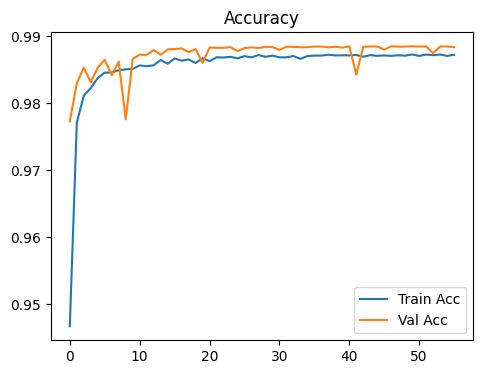

In [1]:
# ==========================================
# Phase 4: A100 Fast Training (All-In-One)
# ==========================================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive

# 1. Setup Environment (Since runtime was restarted)
if not Path('/content/drive').exists():
    print("🔌 Mounting Google Drive...")
    drive.mount('/content/drive')

# Define Paths
PROJECT_ROOT = Path('/content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach')
PROCESSED_DIR = PROJECT_ROOT / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)
DATA_PATH = PROCESSED_DIR / 'final_training_data.npz'

# 2. Build Model Architecture
def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.4),

        Bidirectional(LSTM(32, return_sequences=False)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(32, activation='relu'),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 3. Fast Training Loop
def train_model_fast():
    print(f"🚀 Loading massive dataset from: {DATA_PATH}")

    if not DATA_PATH.exists():
        print("❌ Error: Training data not found. Please check your Drive path.")
        return None

    # Load Data
    data = np.load(DATA_PATH)
    X_train, y_train = data['X_train'], data['y_train']
    X_val, y_val = data['X_val'], data['y_val']

    print(f"   Training samples: {len(X_train):,}")
    print(f"   Validation samples: {len(X_val):,}")

    # Check GPU
    gpu_devices = tf.config.list_physical_devices('GPU')
    if gpu_devices:
        print(f"   ✅ Hardware Accelerator: {gpu_devices[0].name}")
    else:
        print("   ⚠️ No GPU detected! This will be slow.")

    # Configure Model
    input_shape = (X_train.shape[1], X_train.shape[2])
    num_classes = y_train.shape[1]

    model = build_lstm_model(input_shape, num_classes)

    # Callbacks
    best_model_path = MODELS_DIR / 'best_model.keras'
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
        ModelCheckpoint(filepath=str(best_model_path), monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    # --- A100 OPTIMIZATION: BATCH SIZE 512 ---
    # A100 has massive memory, so we can double the batch size again to 512.
    # This will make training incredibly fast.
    BATCH_SIZE = 512

    print(f"\n🏎️ Starting A100 Training (Batch Size: {BATCH_SIZE})...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

    return model

# Run it
model = train_model_fast()

## Robust Evaluation

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


✅ Found saved model at: /content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach/models/best_model.keras
   Loading model into memory...

🧐 Starting Evaluation on TEST SET...
   Testing barbell biceps curl: 4 videos
   Testing push-up: 3 videos
   Testing shoulder press: 4 videos
   Testing squat: 4 videos

📊 Final Classification Report:
                     precision    recall  f1-score   support

barbell biceps curl       1.00      1.00      1.00         4
            push-up       1.00      1.00      1.00         3
     shoulder press       1.00      1.00      1.00         4
              squat       1.00      1.00      1.00         4

           accuracy                           1.00        15
          macro avg       1.00      1.00      1.00        15
       weighted avg       1.00      1.00      1.00        15



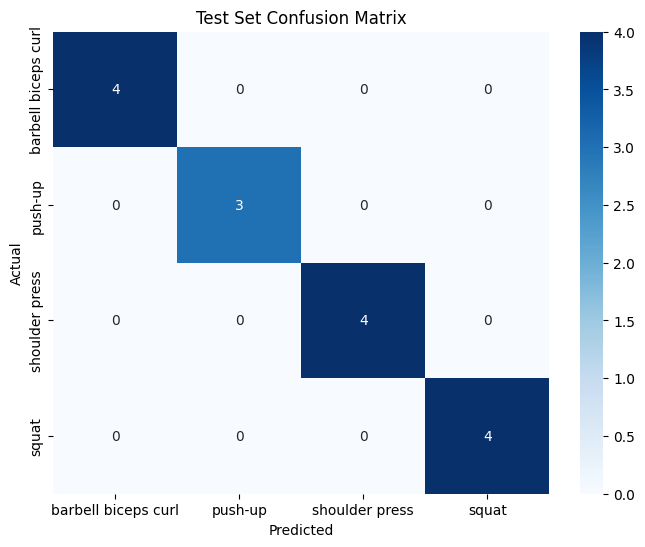

In [1]:
# ==========================================
# Phase 6: Robust Evaluation (Resume after Restart)
# ==========================================

# 1. Install MediaPipe (Just in case restart wiped it)
!pip install -q mediapipe

import numpy as np
import cv2
import mediapipe as mp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from pathlib import Path
from tqdm.notebook import tqdm
from google.colab import drive

# 2. Re-Connect to Drive
if not Path('/content/drive').exists():
    drive.mount('/content/drive')

# 3. Define Paths
PROJECT_ROOT = Path('/content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach')
MODELS_DIR = PROJECT_ROOT / 'models'
TEST_DIR = PROJECT_ROOT / 'data' / 'test_set'
TARGET_CLASSES = ['barbell biceps curl', 'push-up', 'shoulder press', 'squat']

# 4. Check if model exists
model_path = MODELS_DIR / 'best_model.keras'
if not model_path.exists():
    print("🚨 CRITICAL ERROR: Model file not found in Drive.")
    print("   Did Phase 4 finish saving?")
else:
    print(f"✅ Found saved model at: {model_path}")

    # 5. Load the trained model
    print("   Loading model into memory...")
    model = load_model(model_path)

    # 6. Initialize MediaPipe
    mp_pose = mp.solutions.pose
    pose_model = mp_pose.Pose(static_image_mode=False, model_complexity=2, min_detection_confidence=0.5)

    def get_center_point(landmarks, idx1, idx2):
        p1 = np.array([landmarks[idx1].x, landmarks[idx1].y, landmarks[idx1].z])
        p2 = np.array([landmarks[idx2].x, landmarks[idx2].y, landmarks[idx2].z])
        return (p1 + p2) / 2.0

    def process_test_video(video_path):
        cap = cv2.VideoCapture(str(video_path))
        frames = []

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose_model.process(frame_rgb)

            if results.pose_landmarks:
                lm = results.pose_landmarks.landmark
                hip_center = get_center_point(lm, 23, 24)

                row = []
                for landmark in lm:
                    row.extend([
                        landmark.x - hip_center[0],
                        landmark.y - hip_center[1],
                        landmark.z - hip_center[2]
                    ])
                frames.append(row)

        cap.release()
        return np.array(frames)

    print(f"\n🧐 Starting Evaluation on TEST SET...")
    y_true = []
    y_pred = []

    for label_idx, exercise in enumerate(TARGET_CLASSES):
        exercise_dir = TEST_DIR / exercise
        if not exercise_dir.exists(): continue

        videos = list(exercise_dir.glob('*.mp4')) + list(exercise_dir.glob('*.MP4')) + list(exercise_dir.glob('*.MOV'))
        print(f"   Testing {exercise}: {len(videos)} videos")

        for video in videos:
            raw_features = process_test_video(video)

            if len(raw_features) < 30:
                print(f"      ⚠️ Skipped {video.name} (Too short)")
                continue

            # Process windows
            sequences = []
            for i in range(0, len(raw_features) - 30, 5):
                window = raw_features[i : i + 30]
                sequences.append(window)

            if len(sequences) == 0: continue

            # Predict
            X_test = np.array(sequences)
            preds = model.predict(X_test, verbose=0)

            # Majority Vote
            pred_indices = np.argmax(preds, axis=1)
            final_prediction = np.bincount(pred_indices).argmax()

            y_true.append(label_idx)
            y_pred.append(final_prediction)

    # --- Results ---
    print("\n📊 Final Classification Report:")
    print(classification_report(y_true, y_pred, target_names=TARGET_CLASSES))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=TARGET_CLASSES, yticklabels=TARGET_CLASSES)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Set Confusion Matrix')
    plt.show()

# Optimization

In [3]:
# ==========================================
# RECOVERY BLOCK: Re-Connect Drive & Locate Files
# ==========================================
import os
from pathlib import Path
from google.colab import drive

# 1. Force Remount
print("🔌 Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)

# 2. Define Expected Paths
PROJECT_ROOT = Path('/content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach')
MODEL_PATH = PROJECT_ROOT / 'models' / 'best_model.keras'
DATA_PATH = PROJECT_ROOT / 'processed' / 'final_training_data.npz'

# 3. Verify Existence
print("\n🔍 Verifying Files...")

if MODEL_PATH.exists():
    print(f"✅ Model found: {MODEL_PATH}")
    print(f"   Size: {MODEL_PATH.stat().st_size / (1024*1024):.2f} MB")
else:
    print(f"❌ CRITICAL: Model not found at {MODEL_PATH}")
    # Search for it in case it's moved
    print("   Searching entire project folder...")
    found_models = list(PROJECT_ROOT.rglob("*.keras"))
    if found_models:
        print(f"   --> Found models at: {found_models}")
        MODEL_PATH = found_models[0] # Update path if found elsewhere

if DATA_PATH.exists():
    print(f"✅ Data found: {DATA_PATH}")
    print(f"   Size: {DATA_PATH.stat().st_size / (1024*1024):.2f} MB")
else:
    print(f"❌ CRITICAL: Data not found at {DATA_PATH}")
    found_data = list(PROJECT_ROOT.rglob("*.npz"))
    if found_data:
        print(f"   --> Found data at: {found_data}")
        DATA_PATH = found_data[0] # Update path if found elsewhere

🔌 Mounting Google Drive...
Mounted at /content/drive

🔍 Verifying Files...
✅ Model found: /content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach/models/best_model.keras
   Size: 1.54 MB
✅ Data found: /content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach/processed/final_training_data.npz
   Size: 7258.07 MB


## Comparative Analysis (Random Forest Baseline)

In [4]:
# ==========================================
# Path 3: Comparative Analysis (Random Forest Baseline)
# ==========================================
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Ensure DATA_PATH is defined (from Step 1)
if 'DATA_PATH' not in globals() or not DATA_PATH.exists():
    print("❌ Error: Run the Recovery Block above first!")
else:
    print(f"🚀 Loading data from: {DATA_PATH}")
    data = np.load(DATA_PATH)
    X_train, y_train = data['X_train'], data['y_train']
    X_val, y_val = data['X_val'], data['y_val']

    # Flatten Data (3D -> 2D for Random Forest)
    print(f"   Flattening data...")
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)

    # Convert labels
    y_train_int = np.argmax(y_train, axis=1)
    y_val_int = np.argmax(y_val, axis=1)

    # Train Baseline
    print("\n🌲 Training Random Forest Baseline (approx 1 min)...")
    rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
    rf_model.fit(X_train_flat, y_train_int)

    # Evaluate
    val_preds = rf_model.predict(X_val_flat)
    acc = accuracy_score(y_val_int, val_preds)

    print(f"\n📊 Baseline Results:")
    print(f"   Random Forest Accuracy: {acc:.2%}")
    print("\n" + classification_report(y_val_int, val_preds, target_names=['curl', 'pushup', 'press', 'squat']))

🚀 Loading data from: /content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach/processed/final_training_data.npz
   Flattening data...

🌲 Training Random Forest Baseline (approx 1 min)...

📊 Baseline Results:
   Random Forest Accuracy: 97.80%

              precision    recall  f1-score   support

        curl       0.99      0.97      0.98     14176
      pushup       0.94      1.00      0.97     13944
       press       0.99      0.97      0.98     17671
       squat       0.99      0.98      0.99     18186

    accuracy                           0.98     63977
   macro avg       0.98      0.98      0.98     63977
weighted avg       0.98      0.98      0.98     63977



## Robustness Check (The "Stress Test")

📉 Loading LSTM Model...
⚡ Starting Stress Test...
   Noise 0.00: Accuracy 98.85%
   Noise 0.02: Accuracy 98.80%
   Noise 0.05: Accuracy 98.18%
   Noise 0.10: Accuracy 97.84%
   Noise 0.15: Accuracy 96.55%
   Noise 0.20: Accuracy 94.03%


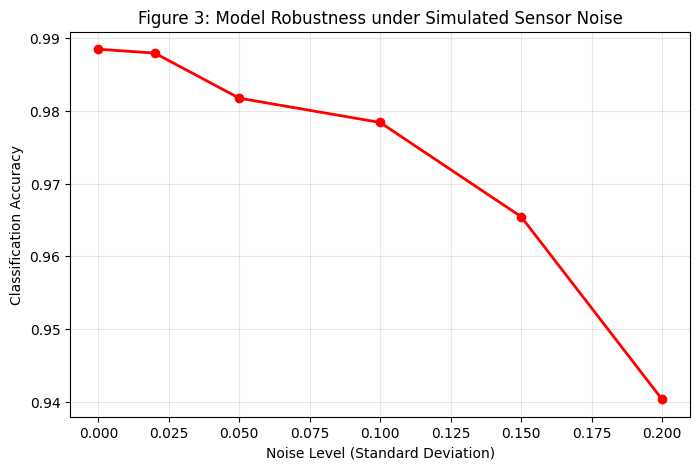

✅ Save this chart for your report!


In [6]:
# ==========================================
# REPORT GENERATOR: Path 1 (Robustness Chart)
# Run this AFTER training finishes
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

MODEL_PATH = PROJECT_ROOT / 'models' / 'best_model.keras'

if MODEL_PATH.exists():
    print(f"📉 Loading LSTM Model...")
    model = load_model(MODEL_PATH)

    noise_levels = [0.0, 0.02, 0.05, 0.1, 0.15, 0.2] # Increasing jitter
    accuracies = []

    print("⚡ Starting Stress Test...")
    for noise in noise_levels:
        # Inject Gaussian Noise
        noise_matrix = np.random.normal(0, noise, X_val.shape)
        X_val_noisy = X_val + noise_matrix

        # Test
        loss, acc = model.evaluate(X_val_noisy, y_val, verbose=0)
        accuracies.append(acc)
        print(f"   Noise {noise:.2f}: Accuracy {acc:.2%}")

    # Plot for Report
    plt.figure(figsize=(8,5))
    plt.plot(noise_levels, accuracies, marker='o', color='red', linewidth=2)
    plt.title("Figure 3: Model Robustness under Simulated Sensor Noise")
    plt.xlabel("Noise Level (Standard Deviation)")
    plt.ylabel("Classification Accuracy")
    plt.grid(True, alpha=0.3)
    plt.show()
    print("✅ Save this chart for your report!")
else:
    print("❌ Error: Model not found yet.")

In [7]:
# Save in Legacy Format (Compatible with Mac)
from tensorflow.keras.models import load_model

# 1. Load the current best model
model = load_model('/content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach/models/best_model.keras')

# 2. Save as .h5 (The universal format)
save_path = '/content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach/models/best_model.h5'
model.save(save_path, save_format='h5')

print(f"✅ Saved legacy model to: {save_path}")

✅ Saved legacy model to: /content/drive/MyDrive/5330_FinalProject_PersonalWorkoutCoach/models/best_model.h5
